In [52]:
import os
import numpy as np
import pandas as pd

import ivfunctions_nested 
import mliv.dgps_nested as dgps
import matplotlib.pyplot as plt

from mliv.rkhs import RKHSIV, ApproxRKHSIVCV, RKHSIVCV, RKHSIVL2CV, RKHSIVL2, RKHS2IVCV


 

In [53]:
fn_number = 0
tau_fn = dgps.get_tau_fn(fn_number)

In [54]:
A, D, B, C, Y, tau_fn = dgps.get_data(3000, 10, 10, tau_fn, 2)


B_test = np.zeros((1000, B.shape[1]))
B_test += np.median(B, axis=0, keepdims=True)
B_test[:, 0] = np.linspace(np.percentile(B[:, 0], 5), np.percentile(B[:, 0], 95), 1000)

B_test = B_test[np.argsort(B_test[:, 0])]
true_fn = tau_fn(B_test)


In [55]:
def nested_npivfit(A, B, C, D, Y, B_test, model, fitargs=None):
    
    B1_test = B_test
    Y = Y
    A1 = A
    B1 = B
    A2 = D
    B2 = C

    #First stage
    if fitargs is not None:
        model.fit(A2, A1, Y, **fitargs)
    else:
        model.fit(A2, A1, Y)
    bridge_fs = model.predict(A1)
    bridge_fs = bridge_fs.reshape(A1.shape[:1] + Y.shape[1:])

    #Second stage
    if fitargs is not None:
        model.fit(B2, B1, bridge_fs, **fitargs)
    else:
        model.fit(B2, B1, bridge_fs)
    
    y_pred = model.predict(B1_test)
    return y_pred.reshape(B1_test.shape[:1] + Y.shape[1:])





In [56]:
from mliv.ensemble import EnsembleIV, EnsembleIVL2, Ensemble2IV, Ensemble2IVL2

In [57]:
# Copyright (c) Microsoft Corporation.
# Licensed under the MIT License.

import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.base import clone
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def _mysign(x):
    return 2 * (x >= 0) - 1


class Ensemble2IV:

    def __init__(self, adversary='auto', learnerg='auto', learnerh='auto',
                 max_abs_value=4, n_iter=100, n_burn_in=10):
        self.adversary = adversary
        self.learnerg = learnerg
        self.learnerh = learnerh
        self.max_abs_value = max_abs_value
        self.n_iter = n_iter
        self.n_burn_in = n_burn_in
        return

    def _check_input(self, A, B, C, D, Y):
        if len(A.shape) == 1:
            A = A.reshape(-1, 1)
        if len(B.shape) == 1:
            B = B.reshape(-1, 1)
        if len(C.shape) == 1:
            C = C.reshape(-1, 1)
        if len(D.shape) == 1:
            D = D.reshape(-1, 1)
        return A, B, C, D, Y.flatten()

    def _get_new_adversary(self):
        return RandomForestRegressor(n_estimators=40, max_depth=2,
                                     bootstrap=True, min_samples_leaf=40, min_impurity_decrease=0.001) if self.adversary == 'auto' else clone(self.adversary)

    def _get_new_learnerg(self):
        return RandomForestClassifier(n_estimators=5, max_depth=2, criterion='gini',
                                      bootstrap=False, min_samples_leaf=40, min_impurity_decrease=0.001) if self.learnerg == 'auto' else clone(self.learnerg)
    
    def _get_new_learnerh(self):
        return RandomForestClassifier(n_estimators=5, max_depth=2, criterion='gini',
                                      bootstrap=False, min_samples_leaf=40, min_impurity_decrease=0.001) if self.learnerh == 'auto' else clone(self.learnerh)

    def fit(self, A, B, C, D, Y):
        A, B, C, D, Y = self._check_input(A, B, C, D, Y)
        max_value = self.max_abs_value
        adversary1 = self._get_new_adversary().fit(D, -Y.flatten())
        adversary2 = self._get_new_adversary().fit(C, np.zeros(Y.shape))
        learnersg = []
        learnersh = []
        h = 0
        g = 0
        for it in range(self.n_iter + self.n_burn_in):
            v = -adversary2.predict(C).flatten()
            v_ = -adversary1.predict(D).flatten() - v
            aug_A = np.vstack([np.zeros((2, A.shape[1])), A])
            aug_B = np.vstack([np.zeros((2, B.shape[1])), B])
            lbl_v = np.concatenate(([-1, 1], _mysign(v)))
            lbl_v_ = np.concatenate(([-1, 1], _mysign(v_)))

            wt_v = np.concatenate(([0, 0], np.abs(v)))
            wt_v_ = np.concatenate(([0, 0], np.abs(v_)))

            learnersg.append(self._get_new_learnerg().fit(
                aug_A, lbl_v_, sample_weight=wt_v_))
            learnersh.append(self._get_new_learnerh().fit(
                aug_B, lbl_v, sample_weight=wt_v))
            g = g * it / (it + 1)
            h = h * it / (it + 1)

            g += max_value * _mysign(learnersg[it].predict_proba(A)[
                :, -1] * learnersg[it].classes_[-1] - 1 / 2) / (it + 1)
            h += max_value * _mysign(learnersh[it].predict_proba(B)[
                :, -1] * learnersh[it].classes_[-1] - 1 / 2) / (it + 1)
            adversary2.fit(C, h - g)
            adversary1.fit(D, g - Y)

        self.learnersg = learnersg[self.n_burn_in:]
        self.learnersh = learnersh[self.n_burn_in:]
        return self

    def predict(self, B, *args):
        if len(args) == 0:
            # Only B_test provided, return h prediction
            return np.mean([self.max_abs_value * _mysign(l.predict_proba(B)
                                                     [:, -1] * l.classes_[-1] - 1 / 2) for l in self.learnersh], axis=0)
        elif len(args) == 1:
            # Two arguments provided, assume the second is A_test
            A = args[0]
            pred_h = np.mean([self.max_abs_value * _mysign(l.predict_proba(B)
                                                     [:, -1] * l.classes_[-1] - 1 / 2) for l in self.learnersh], axis=0)
            pred_g = np.mean([self.max_abs_value * _mysign(l.predict_proba(A)
                                                     [:, -1] * l.classes_[-1] - 1 / 2) for l in self.learnersg], axis=0)
            return pred_h, pred_g

        else:
            # More than one additional argument provided, raise an error
            raise ValueError("predict expects at most two arguments, B_test and optionally A_test")


In [58]:
rfiv_model = EnsembleIV(n_iter=200, max_abs_value=2)
rfiv_pred = nested_npivfit(A, B, C, D, Y, B_test, model=rfiv_model)
 

In [69]:
adversary = RandomForestRegressor(n_estimators=100, max_depth=2,
                                    bootstrap=True, min_samples_leaf=40, min_impurity_decrease=0.001)

learnerh =  RandomForestRegressor(n_estimators=200, max_depth=2,
                                    bootstrap=True, min_samples_leaf=40, min_impurity_decrease=0.001)

rfivl2_model = EnsembleIVL2(n_iter=500, adversary=adversary, learner=learnerh)

rfivl2_pred = nested_npivfit(A, B, C, D, Y, B_test, model=rfivl2_model)

In [60]:


adversary = RandomForestRegressor(n_estimators=100, max_depth=2,
                                    bootstrap=True, min_samples_leaf=40, min_impurity_decrease=0.001)
learnerg = RandomForestClassifier(n_estimators=20, max_depth=2, criterion='gini',
                                    bootstrap=False, min_samples_leaf=40, min_impurity_decrease=0.001)
learnerh = RandomForestClassifier(n_estimators=50, max_depth=2, criterion='gini',
                                    bootstrap=False, min_samples_leaf=40, min_impurity_decrease=0.001)

rfiv2_model = Ensemble2IV(n_iter=500, max_abs_value=2, adversary=adversary, learnerg=learnerg, learnerh=learnerh, n_burn_in=100)

#rfiv2_model = Ensemble2IV(n_iter=200, max_abs_value=4)
rfiv2_pred = rfiv2_model.fit(A, B, C, D, Y).predict(B_test)

In [66]:
adversary = RandomForestRegressor(n_estimators=100, max_depth=2,
                                    bootstrap=True, min_samples_leaf=40, min_impurity_decrease=0.001)
learnerg = RandomForestRegressor(n_estimators=100, max_depth=2,
                                    bootstrap=True, min_samples_leaf=40, min_impurity_decrease=0.001)
learnerh =  RandomForestRegressor(n_estimators=200, max_depth=2,
                                    bootstrap=True, min_samples_leaf=40, min_impurity_decrease=0.001)


rfiv2l2_model = Ensemble2IVL2(n_iter=500, adversary=adversary, learnerg=learnerg, learnerh=learnerh, burn_in=100)

rfiv2l2_pred = rfiv2l2_model.fit(A, B, C, D, Y).predict(B_test)

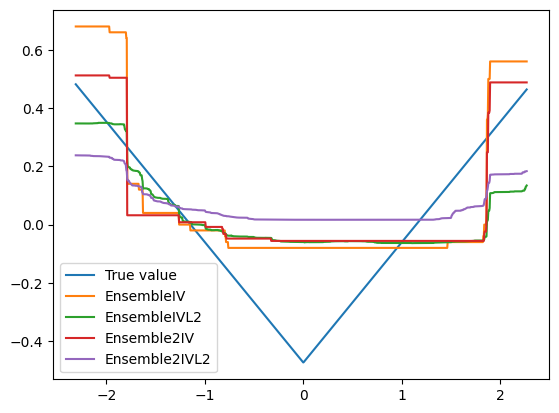

In [70]:
plt.plot(B_test[:, 0], true_fn, label='True value')
plt.plot(B_test[:, 0], rfiv_pred, label='EnsembleIV')
plt.plot(B_test[:, 0], rfivl2_pred, label='EnsembleIVL2')
plt.plot(B_test[:, 0], rfiv2_pred, label='Ensemble2IV')
plt.plot(B_test[:, 0], rfiv2l2_pred, label='Ensemble2IVL2')
plt.legend()
